In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.mixed_method_1.mixed_method_1_operators import extra_term_1
from operators.legendre.legendre_operators import xi_legendre
from operators.hermite.hermite_operators import psi_hermite
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.hermite.hermite_operators import total_mass_hermite, total_momentum_hermite, total_energy_k_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Mixed method #1 method of manufactored solution

In [37]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                    Nv_H=80,
                                    Nv_L=80,
                                    epsilon=1e-2,
                                    v_a=-5,
                                    v_b=5,
                                    alpha=np.sqrt(2),
                                    u=0,
                                    L=20 * np.pi / 3,
                                    dt=1e-2,
                                    T0=0,
                                    T=80,
                                    nu_L=0,
                                    nu_H=0,
                                    gamma=0.5,
                                    construct_integrals=True)

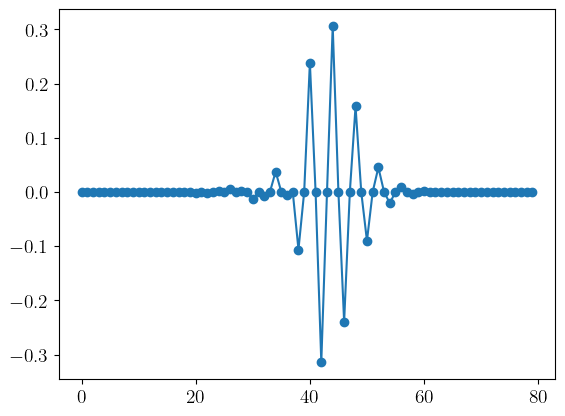

In [38]:
_ = plt.plot(setup.LH_int[:, -1], "-o")
#plt.yscale("symlog", linthresh=1e-15)

In [39]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx)

In [65]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(setup.v_a, setup.v_b, 7000, endpoint=True)
X, V = np.meshgrid(x, v_)

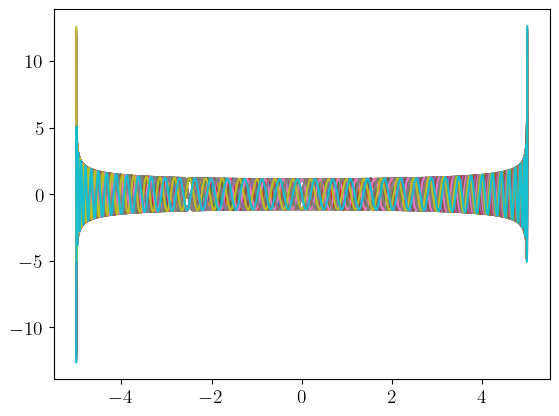

In [66]:
for mm in range(setup.Nv_L):
    plt.plot(v_, xi_legendre(n=mm, v=v_, v_a=setup.v_a, v_b=setup.v_b))

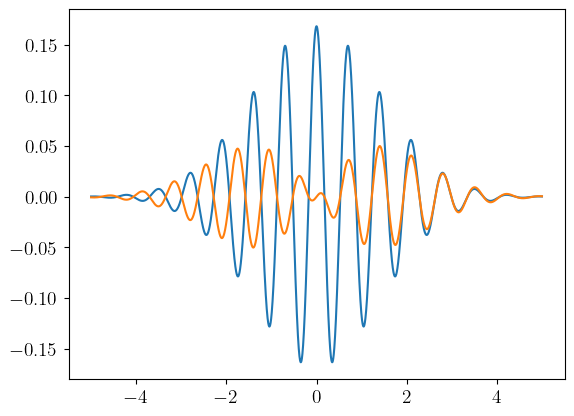

In [67]:
for mm in range(2):
    plt.plot(v_, xi_legendre(n=mm, v=v_, v_a=setup.v_a, v_b=setup.v_b) * psi_hermite(n=setup.Nv_H, alpha_s=setup.alpha, u_s=setup.u, v=v_))

# simulation results

In [68]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1_hermite_legendre/manufactored_solution/sol_u_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1_hermite_legendre/manufactored_solution/sol_t_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(16160, 8001)
(8001,)


In [69]:
runtime = np.load("../../data/mixed_method_1_hermite_legendre/manufactored_solution/sol_runtime_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([5304.702546  , 1379.63480186])

In [70]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [71]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_H,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_L,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_H*setup.Nx, ii], (setup.Nv_H, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_H*setup.Nx:, ii], (setup.Nv_L, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

In [72]:
extra_term_2 = np.zeros((setup.Nx*setup.Nv_L, len(sol_midpoint_t)))
for ii in range(setup.Nv_L):
    extra_term_2[ii*(setup.Nx): (ii + 1)*setup.Nx, :] = -1/(setup.v_b - setup.v_a) * np.sqrt(setup.Nv_H/2) * setup.alpha * (setup.D @ state_e_H[-1, :-1, :]) * setup.LH_int[ii, -1]

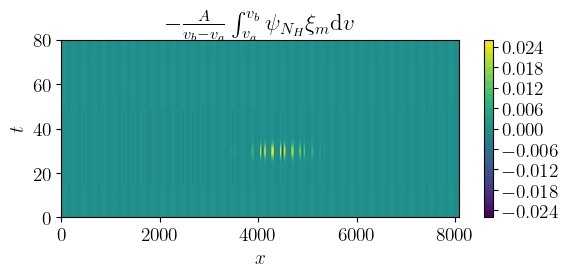

In [73]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(np.arange(len(extra_term_2)), sol_midpoint_t, extra_term_2.T, cmap="viridis", levels=30)
cbar = fig.colorbar(pos)
ax.set_title(r"$- \frac{A}{v_{b} - v_{a}}  \int_{v_{a}}^{v_{b}} \psi_{N_{H}} \xi_{m} \mathrm{d} v$")
ax.set_xlabel("$x$")
# _ = ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3-.05])
# _ = ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

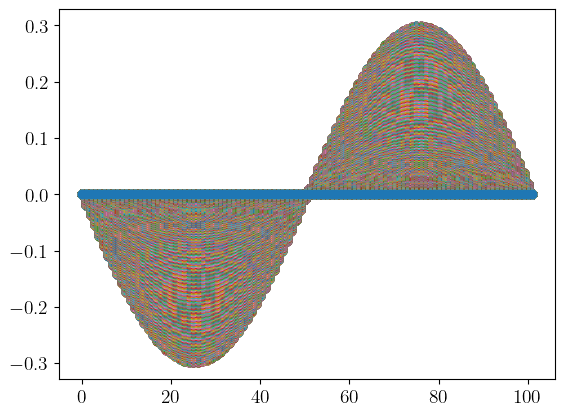

In [74]:
_ = plt.plot(state_e_H[-1, :, :], "-o")

In [75]:
np.shape(np.fft.fft(state_e_H[:, :-1, :], axis=1)[:, 1, :])

(80, 8001)

In [76]:
len(sol_midpoint_t)

8001

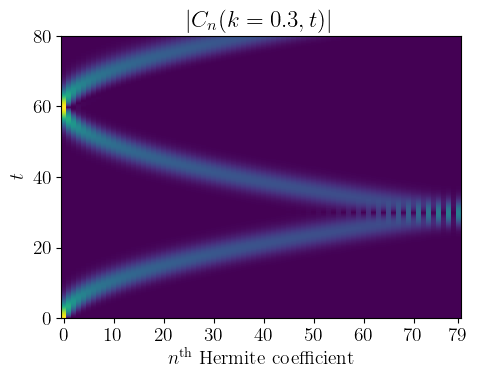

In [90]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.pcolormesh(np.arange(setup.Nv_H), sol_midpoint_t, np.abs(np.fft.fft(state_e_H[:, :-1, :], axis=1)[:, 1, :]).T)
ax.set_ylabel("$t$")
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 79])
ax.set_xlabel("$n^{\mathrm{th}}$ Hermite coefficient")
ax.set_title("$|C_{n}(k=0.3, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/manufactored_solution/hermite_evolution_mixed_method_1.png", dpi=600)

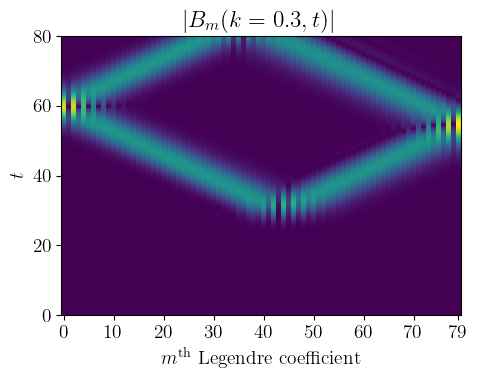

In [91]:
fig, ax = plt.subplots(figsize=(5,4))
ax.pcolormesh(np.arange(setup.Nv_L), sol_midpoint_t, np.abs(np.fft.fft(state_e_L[:, :-1, :], axis=1)[:,1, :]).T)
ax.set_ylabel("$t$")
ax.set_xlabel("$m^{\mathrm{th}}$ Legendre coefficient")
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 79])
ax.set_title("$|B_{m}(k=0.3, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/manufactored_solution/legendre_evolution_mixed_method_1.png", dpi=600)

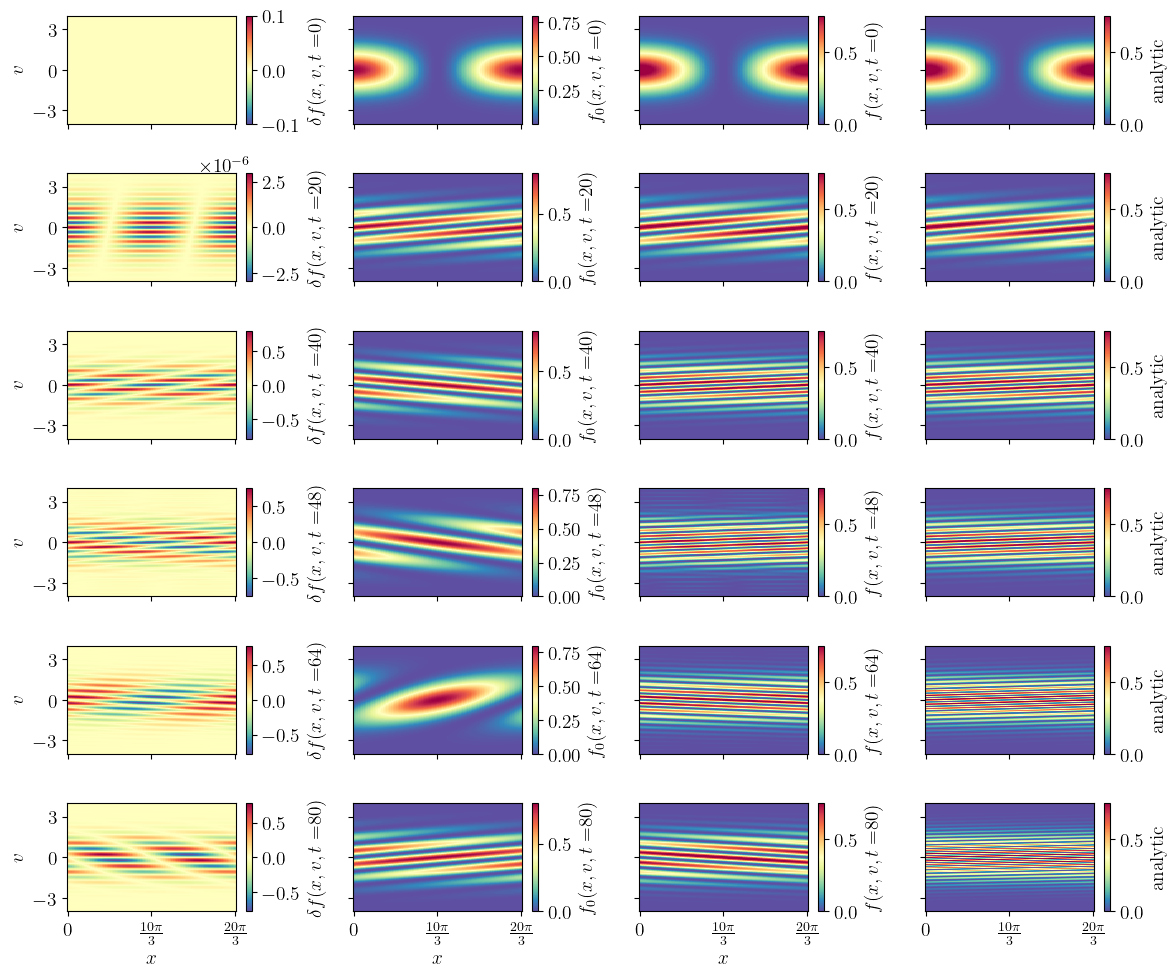

In [79]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12, 10), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([0, int(1*len(sol_midpoint_t)//4), int(2*len(sol_midpoint_t)//4), int(3*len(sol_midpoint_t)//5), int(4*len(sol_midpoint_t)//5), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    distribution2 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_H):
        distribution1 += np.outer(state_e_H[jj, :, ii], psi_hermite(v=v_, u_s=setup.u, alpha_s=setup.alpha, n=jj))
    for jj in range(setup.Nv_L):
        distribution2 += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    pos2 = ax[tt, 0].pcolormesh(x, v_, distribution2.T, cmap="Spectral_r")
    pos1 = ax[tt, 1].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r")
    pos3 = ax[tt, 2].pcolormesh(x, v_, distribution1.T + distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.75)
    pos4 = ax[tt, 3].pcolormesh(x, v_, 1/np.sqrt(np.pi) * np.exp(-0.5 * V**2) * (1 + np.cos(0.3 * (X - V*sol_midpoint_t[ii]))) / setup.alpha, cmap="Spectral_r",  vmin=0, vmax=0.75)
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 4)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar = fig.colorbar(pos2)
    cbar.ax.set_ylabel('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar = fig.colorbar(pos3)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar = fig.colorbar(pos4)
    cbar.ax.set_ylabel("analytic", rotation=90)
    
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 0].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])
ax[tt, 2].set_xlabel("$x$")
ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt, 1].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])

plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/manufactored_solution/manufactored_solution_evolution_mixed_method_1.png", dpi=600)

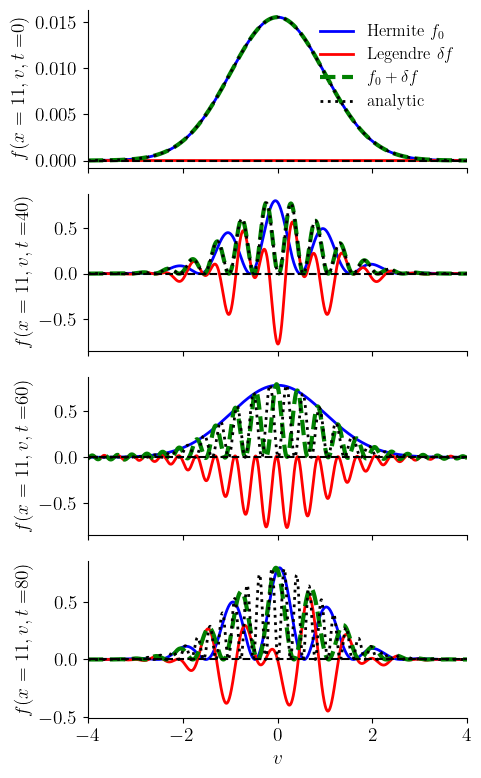

In [80]:
fig, ax = plt.subplots(nrows=4, figsize=(5, 8), sharex=True)
for tt, ii in enumerate([0, int(2*len(sol_midpoint_t)//4), int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_H = np.zeros((len(x), len(v_)))
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_H):
        distribution_H += np.outer(state_e_H[jj, :, ii], psi_hermite(v=v_, u_s=setup.u, alpha_s=setup.alpha, n=jj))
    for jj in range(setup.Nv_L):
        distribution_L += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
        
    _ = ax[tt].plot(v_, distribution_H[55, :], color="blue", label="Hermite $f_{0}$", linewidth=2)
    _ = ax[tt].plot(v_, distribution_L[55, :], color="red", label="Legendre $\delta f$", linewidth=2)
    _ = ax[tt].plot(v_, distribution_L[55, :] + distribution_H[55, :], color="green", ls="--", label=r"$f_{0} + \delta f$", linewidth=3)
    _ = ax[tt].plot(v_, 1/np.sqrt(np.pi) * np.exp(-0.5 * v_**2) * (1 + np.cos(0.3 * (x[55] - v_*sol_midpoint_t[ii]))) / setup.alpha, color="black", ls=":", label=r"analytic", linewidth=2)
    
    ax[tt].spines['right'].set_visible(False)
    ax[tt].spines['top'].set_visible(False)
    ax[tt].set_ylabel("$f(x=11, v, t = $" + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt].set_xlim(-4, 4)
    ax[tt].axhline(0, color="black", ls="--")
legend = ax[0].legend(ncols=1, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
ax[-1].set_xlabel("$v$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/manufactored_solution/f_profile_mixed_method_1.png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [81]:
# compute mass at each timestamp
mass_midpoint_H = np.zeros(len(sol_midpoint_t))
mass_midpoint_L = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint_H[ii] = total_mass_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, dx=setup.dx)
    mass_midpoint_L[ii] = total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

mass_midpoint = mass_midpoint_L + mass_midpoint_H

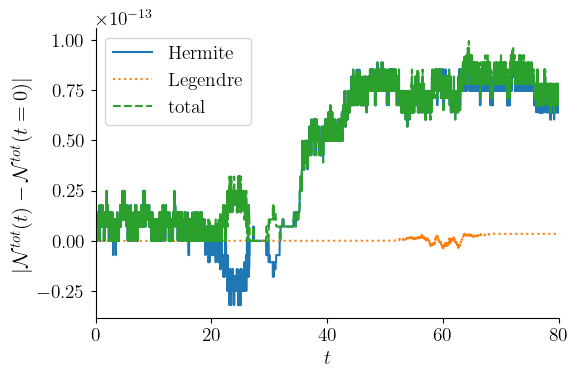

In [82]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, mass_midpoint_H - mass_midpoint_H[0], "-", label="Hermite")
ax.plot(sol_midpoint_t, mass_midpoint_L - mass_midpoint_L[0], ":", label="Legendre")
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "--", label="total")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.legend()
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [83]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u,
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

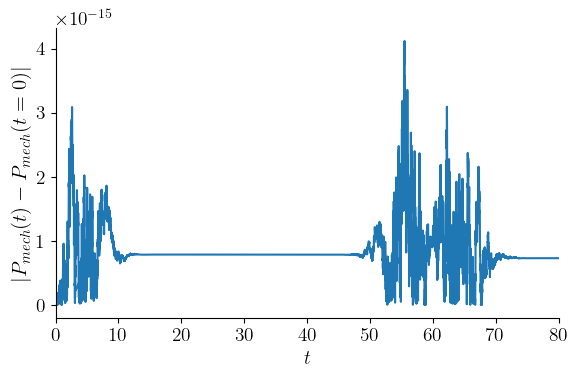

In [84]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [85]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

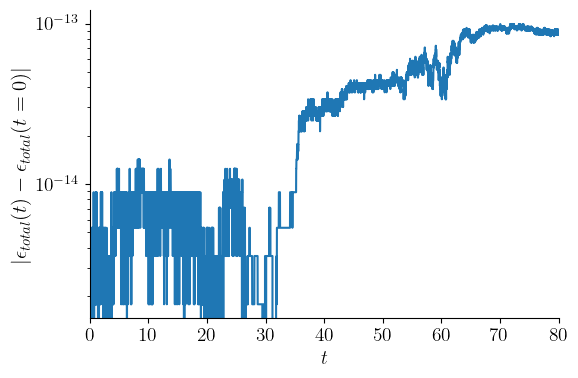

In [86]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

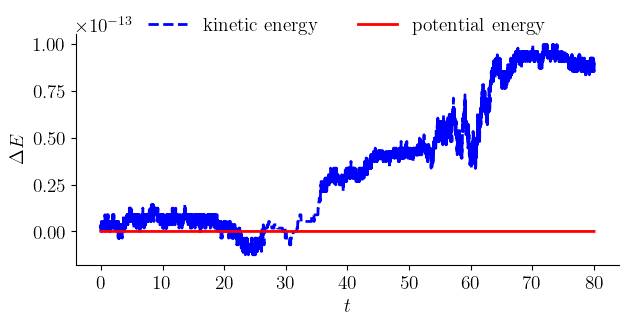

In [87]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

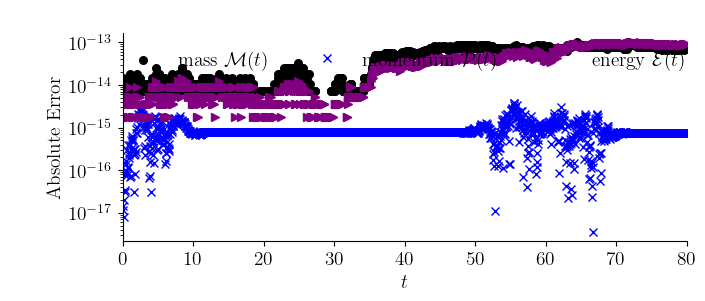

In [63]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()